In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import matplotlib.ticker as ticker
import numpy as np
import os
import progressbar
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data

In [2]:
MAX_LENGTH = 50

class EncoderRNN(nn.Module): 
    def __init__(self, input_size, hidden_size, positional, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p

        self.positional = positional
        self.word_embedding = nn.Embedding(input_size, hidden_size)
        # input_size moet MAX_LENGTH worden
        self.pos_embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        word_embedded = self.word_embedding(input).view(1, 1, -1)
        
        if self.positional:
            pos_embedded = self.pos_embedding(input).view(1, 1, -1)
            output = self.dropout(word_embedded + pos_embedded)
            output = self.linear(output)
            hidden = self.linear(hidden)
        else:
            output, hidden = self.gru(word_embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
class NMT(nn.Module):
    def __init__(self, i2w_english, i2w_french, hidden_size, positional, criterion):
        super(NMT, self).__init__()
        self.encoder = EncoderRNN(len(i2w_english), hidden_size, positional)
        self.decoder = AttnDecoderRNN(hidden_size, len(i2w_french))
        self.criterion = criterion
    
    def forward(self, input_tensor, target_tensor):
        
        loss = 0
        
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        
        encoder_hidden = self.encoder.initHidden()
        encoder_outputs = torch.zeros(MAX_LENGTH, self.encoder.hidden_size)
        
        if input_length > MAX_LENGTH: input_length = MAX_LENGTH
    
        for ei in range(input_length):
            encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token_fr]])
        decoder_hidden = encoder_hidden

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += self.criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token_fr:
                return loss
            
        return loss
    
    def evaluate(self, w2i_english, i2w_french, sentence):
    
        with torch.no_grad():
            input_tensor = sentence_to_tensor(w2i_english, sentence)
            input_length = input_tensor.size()[0]
            encoder_hidden = self.encoder.initHidden()

            encoder_outputs = torch.zeros(MAX_LENGTH, self.encoder.hidden_size)

            if input_length > MAX_LENGTH: input_length = MAX_LENGTH

            for ei in range(input_length):
                encoder_output, encoder_hidden = self.encoder(input_tensor[ei],
                                                         encoder_hidden)
                encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token_fr]])  # SOS

            decoder_hidden = encoder_hidden

            decoded_words = []
            decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

            for di in range(MAX_LENGTH):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token_fr:
                    decoded_words.append("<eos>")
                    break
                else:
                    decoded_words.append(i2w_french[topi.item()])

                decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [3]:
def read_data(file_name):
    """
    Reads the data and returns it in a list.
    """
    
    f = open(file_name, "r")
    return [line.strip().split() for line in f.readlines()]


def word_to_index(file_name):
    """
    Obtains the vocabulary of a file and returns it 
    in a dictionary to be able to use w2i.
    """
    
    file = open(file_name) 
    w2i = json.load(file)
    w2i["<sos>"] = len(w2i)
    return w2i


def index_to_word(dictionary):
    """
    Reverses the dictionary such that i2w can be used.
    """
    
    reversed_dict = {}
    
    for word, index in dictionary.items():
        reversed_dict[index] = word
    reversed_dict[index + 1] = "<sos>" 
    return reversed_dict


def sentence_to_indices(w2i, sentence):
    """
    Returns the indices of the words in a sentence in a list.
    """
    
    return [w2i[word] for word in sentence]


def sentence_to_tensor(w2i, sentence):
    """
    Returns the tensor of a sentence.
    """
    
    indices = sentence_to_indices(w2i, sentence)
    indices.append(w2i["<eos>"])
    return torch.tensor(indices, dtype=torch.long).view(-1, 1)

train_english = read_data("data/train_preprocessed.en")
train_french = read_data("data/train_preprocessed.fr")

val_english = read_data("data/val_preprocessed.en")
val_french = read_data("data/val_preprocessed.fr")

w2i_french = word_to_index("data/train_preprocessed.fr.json")
w2i_english = word_to_index("data/train_preprocessed.en.json")

i2w_french = index_to_word(w2i_french)
i2w_english = index_to_word(w2i_english)

EOS_token_en = w2i_english["<eos>"]
SOS_token_en = w2i_english["<sos>"]

EOS_token_fr = w2i_french["<eos>"]
SOS_token_fr = w2i_french["<sos>"]

teacher_forcing_ratio = 0.5
positional = True

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 1 of 1


100% (1000 of 1000) |####################| Elapsed Time: 0:01:38 Time:  0:01:38


loss: 3372.313117611023


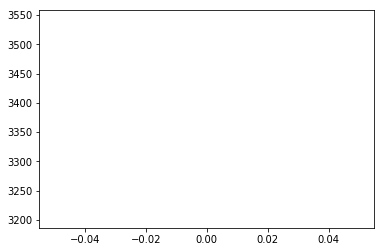

In [4]:
def showPlot(points):
    plt.figure()
#     fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))    


def train(input_sentence, target_sentence, w2i_english, 
          w2i_french, nmt, nmt_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Does one iteration of training.
    """
    
    loss = 0     
    output_sentence = []
    input_tensor = sentence_to_tensor(w2i_english, input_sentence)
    target_tensor = sentence_to_tensor(w2i_french, target_sentence)

    # encoder_hidden = encoder.initHidden()

    nmt_optimizer.zero_grad()

#     input_length = input_tensor.size(0)
#     target_length = target_tensor.size(0)

#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

#     if input_length > MAX_LENGTH: input_length = MAX_LENGTH
    
#     for ei in range(input_length):
#         encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
#         encoder_outputs[ei] = encoder_output[0, 0]

#     decoder_input = torch.tensor([[SOS_token]])
#     decoder_hidden = encoder_hidden
#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
            
#             loss += criterion(decoder_output, target_tensor[di])
#             decoder_input = target_tensor[di]  # Teacher forcing
#     else:
#         # Without teacher forcing: use its own predictions as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
            
#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.squeeze().detach()  # detach from history as input

#             loss += criterion(decoder_output, target_tensor[di])
#             if decoder_input.item() == EOS_token:
#                 break         

    loss = nmt.forward(input_tensor, target_tensor)
    target_length = target_tensor.size(0)
    
    loss.backward()
    nmt_optimizer.step()
    
    return loss.item()/target_length


def train_dataset(w2i_english, w2i_french, train_english, 
                  train_french, nmt, learning_rate):
    """
    Trains the Encoder-Decoder model for the entire data set.
    """
    
    start = time.time()

    nmt_optimizer = optim.SGD(nmt.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    total_loss = 0

#     with progressbar.ProgressBar(max_value=len(train_english)) as bar:
    with progressbar.ProgressBar(max_value=1000) as bar:
#         for iter in range(1, len(train_english) + 1):
        for iter in range(1, 1000+1):
            input_sentence = train_english[iter-1]
            target_sentence = train_french[iter-1]
            loss = train(input_sentence, target_sentence, w2i_english, 
                         w2i_french, nmt, nmt_optimizer, criterion)
            total_loss += loss
            bar.update(iter-1)
    return total_loss


def train_epochs(w2i_english, w2i_french, train_english, train_french,
                nmt, num_epochs, learning_rate=0.01):
    """
    Trains the Encoder-Decoder for a certain amount of epochs.
    """
    
    losses = []
    
    for iter in range(1, num_epochs + 1):
        print("Iteration", iter, "of", num_epochs)
        loss = train_dataset(w2i_english, w2i_french,
                             train_english, train_french, 
                             nmt, learning_rate)
        print("loss:", loss)
        losses.append(loss)
    showPlot(losses)
    
# encoder = EncoderRNN(len(i2w_english), 256, positional)
# decoder = AttnDecoderRNN(256, len(i2w_french))
criterion = nn.NLLLoss()
nmt = NMT(i2w_english, i2w_french, 256, positional, criterion)
train_epochs(w2i_english, w2i_french, train_english, train_french,
             nmt, 1)

In [5]:
predictions = []
    
for sentence in val_english:
    predicted_words, attentions = nmt.evaluate(w2i_english, i2w_french, sentence)
    predicted_sentence = ' '.join(predicted_words)
    predictions.append(predicted_sentence)

In [8]:
def save_predictions(predictions, file_name):
    """
    Saves the encoded predicted sentences decoded to a file.
    """
    
    with open("temp_encoded.txt", "w") as f:
        for sentence in predictions:
            f.write(sentence + "\n")
    f.close()
    
    command = "sed -r 's/(@@ )|(@@ ?$)//g' temp_encoded.txt > " + file_name
    os.system(command)
    os.remove("temp_encoded.txt")

save_predictions(predictions, "test_val.txt")

# Old stuff

In [ ]:
# def evaluate(encoder, decoder, w2i_english, i2w_french,
#              sentence, max_length=MAX_LENGTH):
#     """
#     Evaluates a sentence.
#     """
    
#     with torch.no_grad():
#         input_tensor = sentence_to_tensor(w2i_english, sentence)
#         input_length = input_tensor.size()[0]
#         encoder_hidden = encoder.initHidden()

#         encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

#         if input_length > MAX_LENGTH: input_length = MAX_LENGTH
        
#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei],
#                                                      encoder_hidden)
#             encoder_outputs[ei] += encoder_output[0, 0]

#         decoder_input = torch.tensor([[SOS_token]])  # SOS

#         decoder_hidden = encoder_hidden

#         decoded_words = []
#         decoder_attentions = torch.zeros(max_length, max_length)

#         for di in range(max_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             decoder_attentions[di] = decoder_attention.data
#             topv, topi = decoder_output.data.topk(1)
#             if topi.item() == EOS_token_fr:
#                 decoded_words.append("<eos>")
#                 break
#             else:
#                 decoded_words.append(i2w_french[topi.item()])

#             decoder_input = topi.squeeze().detach()

#         return decoded_words, decoder_attentions[:di + 1]
    
    
# def evaluate_dataset(encoder, decoder, val_english):
#     """
#     Evaluates the entire validation set.
#     """
    
#     predictions = []
    
#     for sentence in val_english:
#         predicted_words, attentions = evaluate(encoder, decoder, w2i_english, i2w_french, sentence)
#         predicted_sentence = ' '.join(predicted_words)
#         predictions.append(predicted_sentence)
#     return predictions
        

# def save_predictions(predictions, file_name):
#     """
#     Saves the encoded predicted sentences decoded to a file.
#     """
    
#     with open("temp_encoded.txt", "w") as f:
#         for sentence in predictions:
#             f.write(sentence + "\n")
#     f.close()
    
#     command = "sed -r 's/(@@ )|(@@ ?$)//g' temp_encoded.txt > " + file_name
#     os.system(command)
#     os.remove("temp_encoded.txt")
    

# predictions = evaluate_dataset(encoder, decoder, val_english)
# save_predictions(predictions, "test_val.txt")

In [ ]:
# print(len(train_english))